## Zero Black Derman Toy Model 2019

The goal of this notebook is to define a class for calibrating the 2019 Zero-Black-Derman-Toy (BDT) model.

The authors didn't give any insight on how the calibration was performed, so we developed our own implementation using the paper's calibration equations.

We obtain anyway very good results in term of error minimization

In [1]:
import numpy as np
import scipy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.optimize import minimize

In [2]:
class Tree:
    """
    This class implements the Zero-Black_Derman-Toy model.
    It allows calibration of the model using the original Paper's calibration formulas
    """
    def __init__(self,dt,p,q,x0):
        """
        Initializes the  tree model.

        Parameters:
        - dt: Time step size in years.
        - p: Probability to go to the low interest rate region
        - q: Probability to get out of the low interest rate region
        """
        self.p=p
        self.q=q
        self.x0=x0
        self.dt=dt
        self.rates = []
        self.T=0
        self.eq2=0
        self.eq3=0
    
    def Print(self):
        
        """
        Simple function to Print the Tree
        
        """
        for time in range(len(self.rates)):
            print(f"{time} -> {[f'{rate:.5f}' for rate in self.rates[time]]}")
    
    
    
    def ZCB_Pricer(self,time):
        
        """
        This function allows to compute the price of a zero coupond bond of a given maturity once the model 
        has been calibrated.
        It is also often use during the calibration as well
        
         Parameters:
        - time: Maturity in terms of the number of time steps.

        Returns:
        - The computed price of the ZCB.
        
        """
        if(time>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        if(time==0):
            raise Exception("can't do this time")
        if (time==1):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            Prices_tree.append(np.ones(3))
            Prices_tree[0]=np.array([1/(1+self.rates[0][0])])
        else:
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            for t in range(1,time):
                Prices_tree.append(np.zeros(t+2))
            Prices_tree.append(np.ones(time+2))
            for t in range(time-1,0,-1):
                for grade in range(0,t):
                    Prices_tree[t][grade]=0.5*(Prices_tree[t+1][grade]+Prices_tree[t+1][grade+1])/(1+self.rates[t][grade])
                    
                Prices_tree[t][t]=(((1-self.p)/2)*(Prices_tree[t+1][t]+Prices_tree[t+1][t+1])/(1+self.rates[t][t])) + self.p*(Prices_tree[t+1][t+2])/(1+self.rates[t][t])
                Prices_tree[t][t+1]=(((self.q)*(Prices_tree[t+1][t+1]))+ ((1-self.q)*(Prices_tree[t+1][t+2])))/(1+self.x0)
            
            Prices_tree[0]=np.array([(((1-self.p)/2)*(Prices_tree[1][0]+Prices_tree[1][1]) + (self.p)*(Prices_tree[1][2]))/(1+self.rates[0][0])])
        return Prices_tree
    
    def Bu_pricer(self,time):
        """
        Computes the price of a ZCB following only the upward path of the tree.

        This function is primarily used for calibration.

        Parameters:
        - time: Maturity in terms of time steps.

        Returns:
        - The computed price of the ZCB
        """
        
        if(time>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        if(time<=1):
            raise Exception("can't do this time")
        if(time==2):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            Prices_tree.append(np.ones(2))
            Prices_tree[0]=np.array([1/(1+self.rates[1][0])])
        else:
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            for t in range(1,time-1):
                Prices_tree.append(np.zeros(t+1))
            Prices_tree.append(np.ones(time))
            for t in range(time-2,-1,-1):
                for grade in range(0,t+1):
                    Prices_tree[t][grade]=0.5*(Prices_tree[t+1][grade]+Prices_tree[t+1][grade+1])/(1+self.rates[t+1][grade])                    
        return Prices_tree
    
    def Bd_pricer(self,time):
        """
        Computes the price of a ZCB following only the downward path of the tree.

        This function is primarily used for calibration.

        Parameters:
        - time: Maturity in terms of time steps.

        Returns:
        - The computed price of the ZCB
        """
        
        if(time>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        if(time<=1):
            raise Exception("can't do this time")
        if(time==2):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            Prices_tree.append(np.ones(3))
            Prices_tree[0]=np.array([1/(1+self.rates[1][1])])
        if(time>2):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            for t in range(1,time-1):
                Prices_tree.append(np.zeros(t+2))
            Prices_tree.append(np.ones(time+1))
            for t in range(time-2,-1,-1):
                for grade in range(0,t):
                    Prices_tree[t][grade]=0.5*(Prices_tree[t+1][grade]+Prices_tree[t+1][grade+1])/(1+self.rates[t+1][grade+1])
                if(t!=0):
                    Prices_tree[t][t]=((((1-self.p)/2)*(Prices_tree[t+1][t+1]+Prices_tree[t+1][t]))/(1+self.rates[t+1][t+1])) + self.p*(Prices_tree[t+1][t+2])/(1+self.rates[t+1][t+1])
                    Prices_tree[t][t+1]=(((self.q)*(Prices_tree[t+1][t+1]))+ ((1-self.q)*(Prices_tree[t+1][t+2])))/(1+self.x0)
                else:
                    Prices_tree[0]=np.array([ ((((1-self.p)/2)*(Prices_tree[1][-2]+Prices_tree[1][-3])) + self.p*(Prices_tree[1][-1]))/(1+self.rates[1][1])])
                    
        return Prices_tree

    def B0_pricer(self,time):
        """
        Computes the price of a ZCB following  the low interest rate path of the tree.

        This function is primarily used for calibration.

        Parameters:
        - time: Maturity in terms of time steps.

        Returns:
        - The computed price of the ZCB
        """
        if(time>self.T):
            raise Exception("The tree is not calibrated to price for this maturity")
        if(time<=1):
            raise Exception("can't do this time")
        if(time==2):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            Prices_tree.append(np.ones(2))
            Prices_tree[0]=np.array([1/(1+self.x0)])
        if(time==3):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            Prices_tree.append(np.zeros(2))
            Prices_tree.append(np.ones(3))
            Prices_tree[1][0]=(((Prices_tree[2][0]+Prices_tree[2][1])*(1-self.p)/2)+(self.p)*Prices_tree[2][2])/(1+self.rates[2][2])       
            Prices_tree[1][1]=((Prices_tree[2][1]*self.q)+(Prices_tree[2][2]*(1-self.q)))/(1+self.x0)
            Prices_tree[0][0]=(self.q*Prices_tree[1][0]+(1-self.q)*Prices_tree[1][1])/(1+self.x0)
        if(time==4):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            Prices_tree.append(np.zeros(2))
            Prices_tree.append(np.zeros(3))
            Prices_tree.append(np.ones(4))
            Prices_tree[2][0]=0.5*(Prices_tree[3][0]+Prices_tree[3][1])/(1+self.rates[3][2])
            Prices_tree[2][1]=(((Prices_tree[3][1]+Prices_tree[3][2])*(1-self.p)/2)+(self.p)*Prices_tree[3][3])/(1+self.rates[3][3])       
            Prices_tree[2][2]=((Prices_tree[3][2]*self.q)+(Prices_tree[3][3]*(1-self.q)))/(1+self.x0)
            Prices_tree[1][0]=(((Prices_tree[2][0]+Prices_tree[2][1])*(1-self.p)/2)+(self.p)*Prices_tree[2][2])/(1+self.rates[2][2])       
            Prices_tree[1][1]=(Prices_tree[2][1]*self.q)+(Prices_tree[2][2]*(1-self.q))/(1+self.x0)
            Prices_tree[0][0]=(self.q*Prices_tree[1][0]+(1-self.q)*Prices_tree[1][1])/(1+self.x0)
        if(time>4):
            Prices_tree=[]
            Prices_tree.append(np.zeros(1))
            for t in range(1,time-1):
                Prices_tree.append(np.zeros(t+1))
            Prices_tree.append(np.ones(time))
            
            for t in range(time-2,2,-1):
                for grade in range(0,t+1):
                    if(grade!=t and grade!=t+1):
                        Prices_tree[t][grade]=0.5*(Prices_tree[t+1][grade]+Prices_tree[t+1][grade+1])/(1+self.rates[t+1][grade+2])
                    Prices_tree[t][-2]=(((Prices_tree[t+1][t-1]+Prices_tree[t+1][t])*(1-self.p)/2)+(self.p)*Prices_tree[t+1][t+1])/(1+self.rates[t+1][t+1])    
                    Prices_tree[t][-1]=(Prices_tree[t+1][-2]*self.q)+(Prices_tree[t+1][-1]*(1-self.q))/(1+self.x0)
            Prices_tree[2][0]=0.5*(Prices_tree[3][0]+Prices_tree[3][1])/(1+self.rates[3][2])
            Prices_tree[2][1]=(((Prices_tree[3][1]+Prices_tree[3][2])*(1-self.p)/2)+(self.p)*Prices_tree[3][3])/(1+self.rates[3][3])       
            Prices_tree[2][2]=((Prices_tree[3][2]*self.q)+(Prices_tree[3][3]*(1-self.q)))/(1+self.x0)
            Prices_tree[1][0]=(((Prices_tree[2][0]+Prices_tree[2][1])*(1-self.p)/2)+(self.p)*Prices_tree[2][2])/(1+self.rates[2][2])       
            Prices_tree[1][1]=(Prices_tree[2][1]*self.q)+(Prices_tree[2][2]*(1-self.q))/(1+self.x0)
            Prices_tree[0][0]=(self.q*Prices_tree[1][0]+(1-self.q)*Prices_tree[1][1])/(1+self.x0)
                    
        return Prices_tree
    
    
    def equation2(self,vars,Beta2,Price):
        
        """
        First Equation to optimize for, here we ensure that we match the given Yield and Volatility
        """
        
        yu,yd=vars
        lu=np.log(yu/self.x0)
        ld=np.log(yd/self.x0)
        r12=yu
        r11=yd

        
        Bu=1/(1+yu)
        Bd=1/(1+yd)
        B0=1/(1+self.x0)
        

        eq1=(((1-(self.p*self.p))/4)*(lu*lu+ld*ld))-(((1-self.p)*(1-self.p))/2)*lu*ld -Beta2
        eq2=(1/(1+self.rates[-1][0]))*((((1-self.p)/2) *(Bu+Bd))+(self.p*B0) ) - Price
        
        
        return (eq1)**2+(eq2)**2
    
    def equation3(self,vars,Price,sigma,T,Beta):
        """
        Second Equation to optimize for, here we ensure that we match the given Yield and Volatility
        as well as the prices corresponding to the zero coupon bonds after one step (starting from T=1)
        """
        
        r_top,r1=vars
            
        guesses = r_top * np.exp(-2 * sigma * np.arange(T-1))
        if(guesses[-1]<r1):
            return 1
        extra_values = [r1,self.x0]

        guesses = np.append(guesses, extra_values)
        new=np.array(guesses)
        
        self.rates[-1]=new
        
        predicted_price=self.ZCB_Pricer(self.T)[0][0]
        predicted_price_Bu=self.Bu_pricer(self.T)[0][0]
        predicted_price_Bd=self.Bd_pricer(self.T)[0][0]
        predicted_price_B0=self.B0_pricer(self.T)[0][0]

        yd = (1/predicted_price_Bd)**(1/(self.T-1)) - 1
        yu = (1/predicted_price_Bu)**(1/(self.T-1)) - 1
        y0 = (1/predicted_price_B0)**(1/(self.T-1)) - 1
       

        
        lu=np.log(yu/y0)
        ld=np.log(yd/y0)
        
        
        
        l1=np.log(r1/self.x0)
        l2=np.log(self.rates[-1][-3]/self.x0)
        
        eq1=predicted_price-Price
        self.eq2=(((1-self.p*self.p)/4)*(l1*l1+l2*l2))-((((1-self.p)**2)/2)*l1*l2)- sigma*sigma
        self.eq3=(((1-self.p*self.p)/4)*(lu*lu+ld*ld))-((((1-self.p)**2)/2)*lu*ld)- Beta*Beta
        
        return (eq1)**2
    
    
    
    def Add_layer(self,Yield,Beta):
        """
        This is the function that allows us to add a new layer given the information about volatility and yield
        
        Parameters:
        - Yield: Yield associated to the next maturity
        - Beta: Volatility associated to the next maturity

        Returns:
        - Nothing, just calibrates the model
        
        """
        if(self.T==0):
            self.T+=1
            self.rates.append(np.array([Yield]))
            
        elif (self.T==1):
            self.T+=1
            Beta2=Beta
            Price=1/((1+Yield)**2)
            initial_guess= [0.1,0.01]
            
            solution = minimize(
            self.equation2, 
            initial_guess, 
            args=(Beta2, Price), 
            bounds=[(1e-6, 1- 1e-6), (1e-6, 1- 1e-6)],  
            method="SLSQP",  
            tol=1e-12,  
            )

            yu_opt,yd_opt=solution.x
            self.rates.append([yu_opt,yd_opt,self.x0])  
        else:            
            best_solution = None
            best_sigma = None
            min_error = float("inf")  
            self.rates.append(np.zeros(len(self.rates[-1]))+1)
            self.T+=1
            Price=1/((1+Yield)**(self.T))
            initial_guess= [self.rates[-2][0],self.rates[-2][-1]]
            for sigma_try in np.arange(0,2*Beta,0.001):
                
                solution = minimize(
                self.equation3, 
                initial_guess, 
                args=(Price,sigma_try,self.T,Beta), 
                bounds=[(1e-6, 1- 1e-6),(self.x0, 1-1e-6)],  
                method="SLSQP",  
                tol=1e-12,  
                )  
                final_error = self.equation3(solution.x, Price,sigma_try, self.T,Beta)
                final_error=self.eq3**2+self.eq2**2
                if final_error < min_error:
                    min_error = final_error
                    best_solution = solution.x
                    best_sigma = sigma_try 
                    
            guesses = best_solution[0] * np.exp(-2 * best_sigma * np.arange(self.T-1))
            extra_values = [best_solution[1],self.x0]
            guesses = np.append(guesses, extra_values)
            new=np.array(guesses)
            self.rates[-1]=new
    def Calibrate(self,Inputs):
        """
        This is the function to calibrate the whole model
        Parameters:
        -Inputs: Vector of yields and volatilities
        """
        for val in Inputs:
            self.Add_layer(val[0],val[1])

def plot_mixed_tree(tree, dt, title, ylabel, xlabel):
    """
    Plots a tree starting with trinomial edges for the first level
    and then binomial edges for subsequent levels.

    Parameters:
    - dt: Time step size
    - title: Plot title
    - ylabel: Y-axis label
    - xlabel: X-axis label
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    spacing = 1

    for time in range(len(tree) - 1):
        nodes_current = len(tree[time])
        nodes_next = len(tree[time + 1])

        for i in range(nodes_current):
            y_current = -i * spacing + (nodes_current - 1) * spacing / 2

            if time == 0: 
                for offset in [0, 1, 2]:
                    y_next = -(i + offset) * spacing + (nodes_next - 1) * spacing / 2
                    ax.plot([time * dt, (time + 1) * dt], [y_current, y_next], 'k-', lw=1)
            else:  
                for offset in [0, 1]:
                    y_next = -(i + offset) * spacing + (nodes_next - 1) * spacing / 2
                    ax.plot([time * dt, (time + 1) * dt], [y_current, y_next], 'k-', lw=1)

            ax.text(time * dt, y_current, f"{tree[time][i]:.4f}", fontsize=9,
                    ha='center', va='center', color='black',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

    final_time = (len(tree) - 1) * dt
    nodes_final = len(tree[-1])
    for i in range(nodes_final):
        y_final = -i * spacing + (nodes_final - 1) * spacing / 2
        ax.text(final_time, y_final, f"{tree[-1][i]:.4f}", fontsize=9,
                ha='center', va='center', color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.legend([f"Time step = {dt}"], loc="upper left")

    plt.show()



In [3]:
tree=Tree(1,0.02,0.01,0.0025)
Yield = [0.0260, 0.0250, 0.0287,0.031]
Vol = [0.400, 0.340, 0.245,0.289]
Inputs=[[Yield[i],Vol[i]] for i in range (len(Yield))]
tree.Calibrate(Inputs)

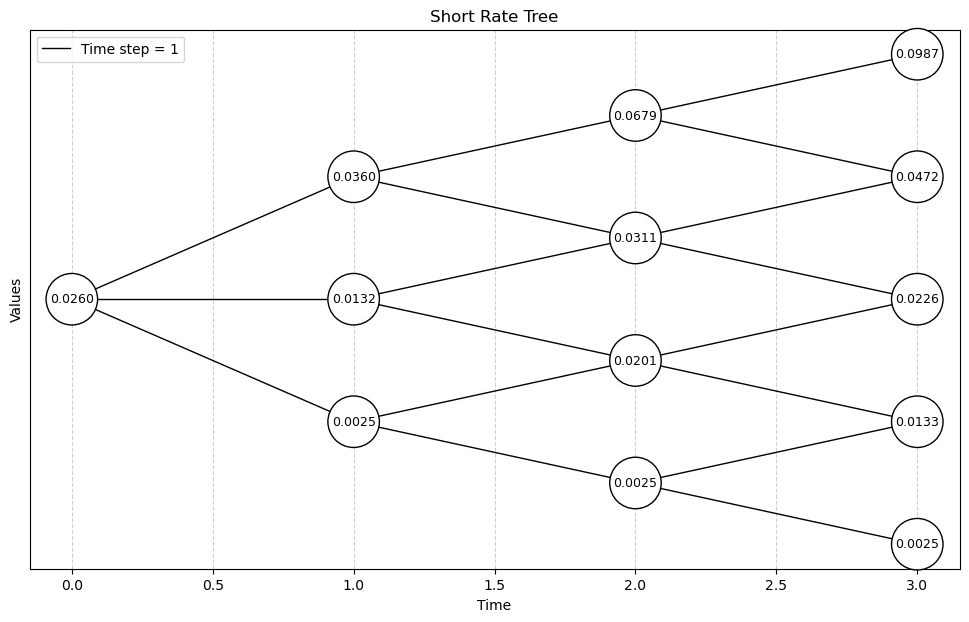

In [4]:
plot_mixed_tree(tree.rates, dt=1, title="Short Rate Tree", 
                ylabel="Values", xlabel="Time")

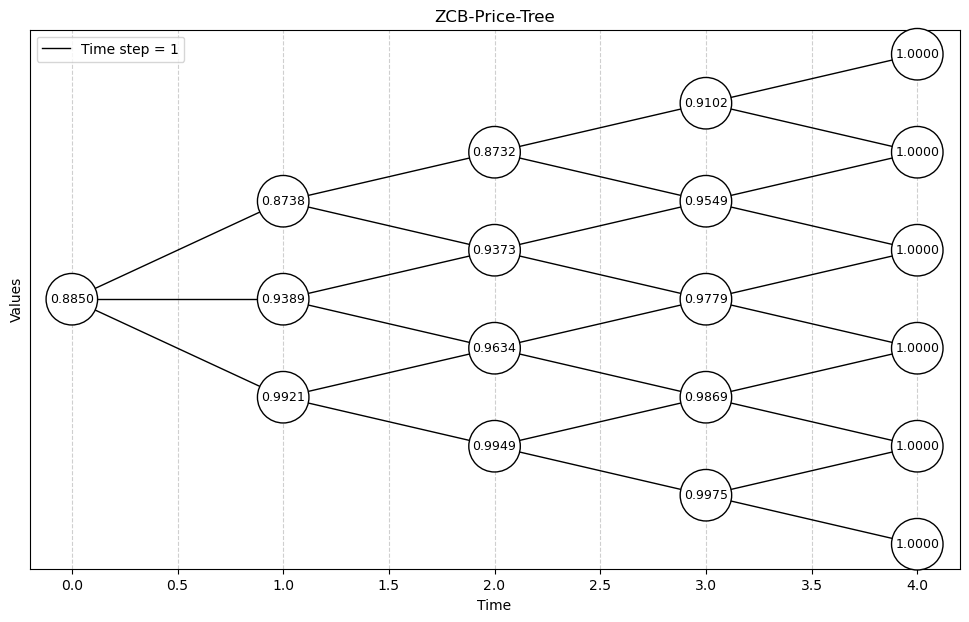

In [5]:
plot_mixed_tree(tree.ZCB_Pricer(4), dt=1, title="ZCB-Price-Tree", 
                ylabel="Values", xlabel="Time")